<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/churn_competition_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание оттока пользователей

В этом [соревновании](https://www.kaggle.com/competitions/advanced-dls-spring-2021/overview/description) нам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаемся удержать его, предложив какие-то бонусы. 

На станице с данными мы загрузим два файла - train.csv (содержит колонки признаков и целевую переменную) и test.csv (содержит только колонки признаков). В качестве ответа нам необходимо загрузить предсказания вероятностей ухода клиентов для test.csv. Пример файла с предскзаниями - submission.csv.

В данном соревновании решения будут сравниваться по метрике ROC-AUC.

## Исследование данных

Импортируем необходимы библиотеки, модули, классы и функции:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.3 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool

### Загрузка и предобработка данных

Загрузим обучающую выборку и сохраним ее в переменной `df`: 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Start/Datasets/Churn/train.csv')

Выведим первые 5 строк таблицы:

In [ ]:
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Посмотрим на общую информацию о таблице:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Всего у нас 5 282 наблюдения, 19 признаков и одна целевая переменная `Churn`.

Проверим пропуски в признаках:

In [ ]:
df.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Пропуски в обучающей выборке отсутствуют.

Строковый тип данных в признаке `TotalSpent` необходимо поменять на числовой. Для этого проверим наличие пустых строк c пробелами в столбце `TotalSpent`:

In [ ]:
df[df['TotalSpent'].str.isspace()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Заменим пустые строки с пробелами на нули:

In [ ]:
df['TotalSpent'] = df['TotalSpent'].replace(' ', '0')

А теперь поменяем тип данных:

In [ ]:
df['TotalSpent'] = df['TotalSpent'].astype(float)

Проверим наличие пустых строк с пробелами и без пробелов во всех категориальных признаках c типом данных `object`:

In [ ]:
df.select_dtypes(include='object').isin([' ', '']).sum()

Sex                         0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

### Признаки

Создадим списки наименований количественных, категориальных признаков и целевой переменной.

Количественные признаки:

In [ ]:
num_features = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
num_features

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

Категориальные признаки:

In [ ]:
cat_features = ['Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod']
cat_features

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

Полный список признаков:

In [ ]:
X = num_features + cat_features
X

['ClientPeriod',
 'MonthlySpending',
 'TotalSpent',
 'Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

Целевая переменная:

In [ ]:
y = 'Churn'

## Анализ данных 

### Количественные признаки

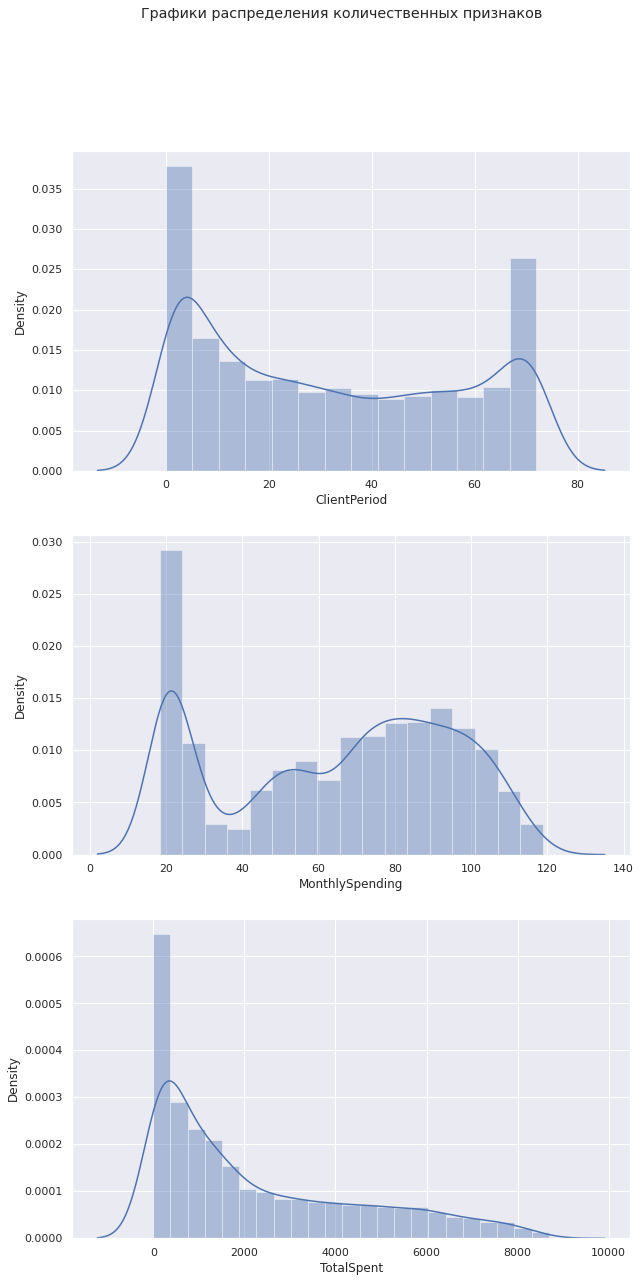

<Figure size 1080x360 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10, 20))
plt.figure()
fig.suptitle('Графики распределения количественных признаков')
sns.distplot( df['ClientPeriod'], ax=axes[0])
sns.distplot(df['MonthlySpending'], ax=axes[1])
sns.distplot(df['TotalSpent'], ax=axes[2])
plt.show()

### Категориальные признаки

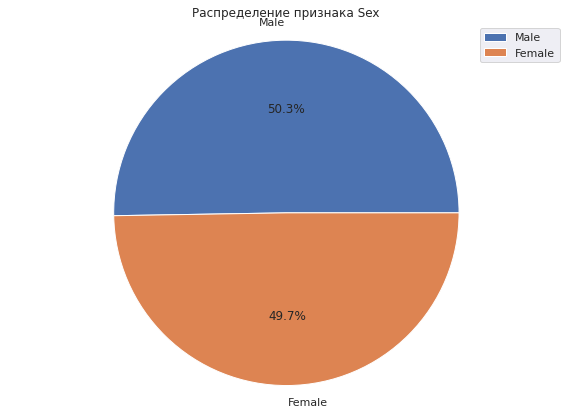

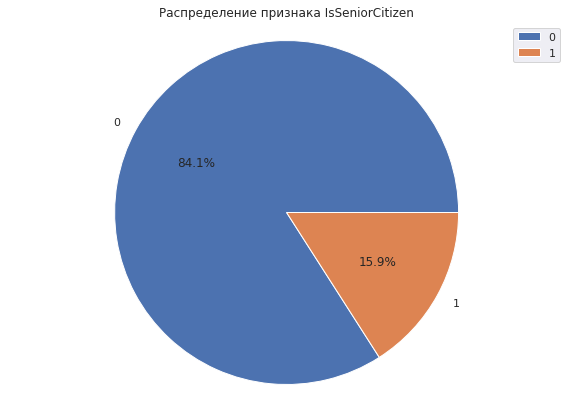

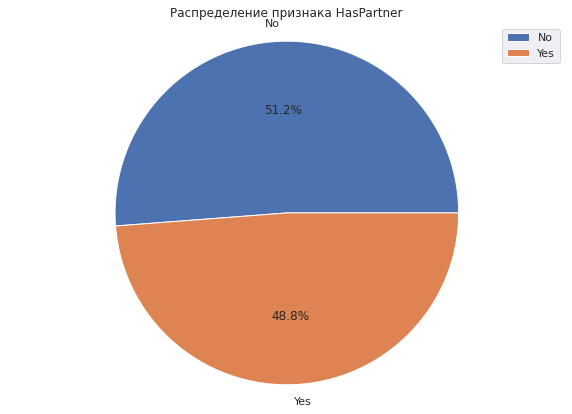

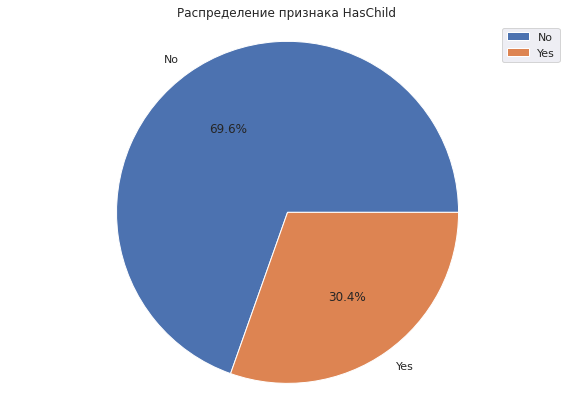

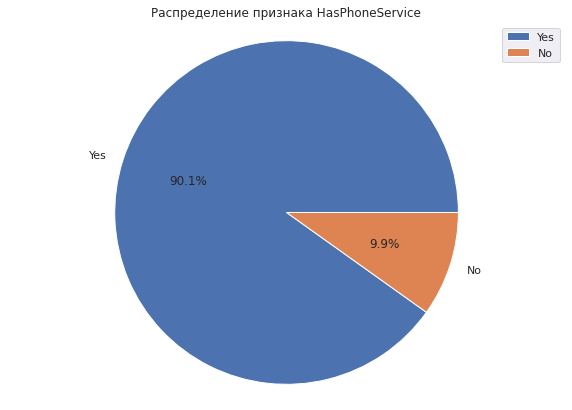

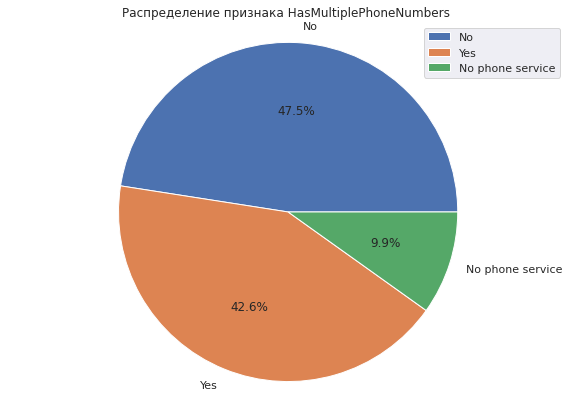

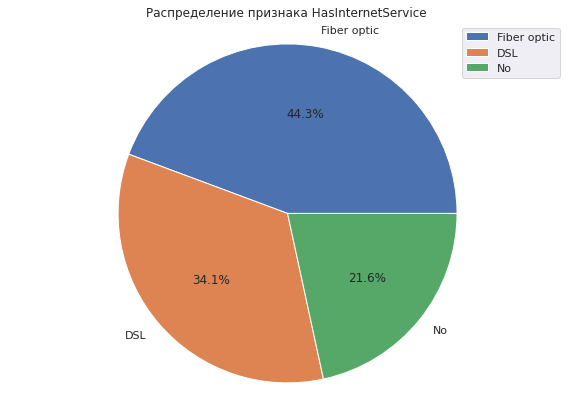

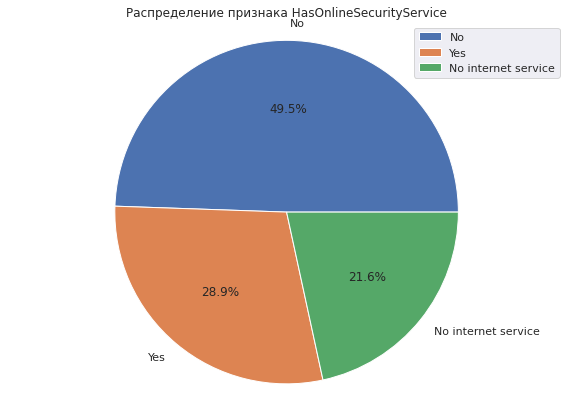

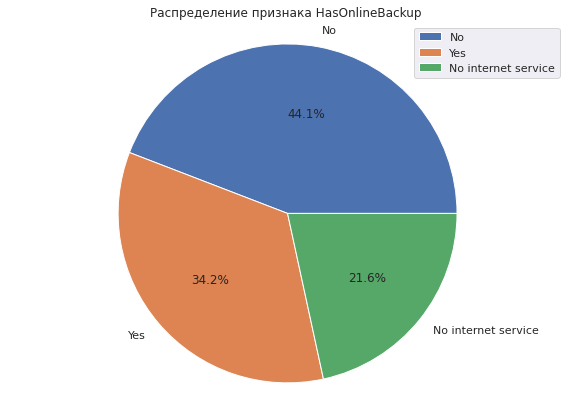

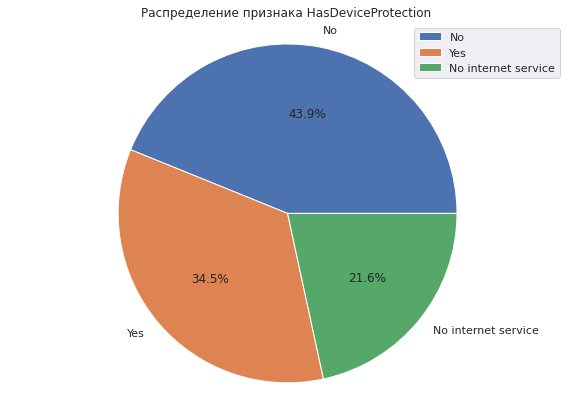

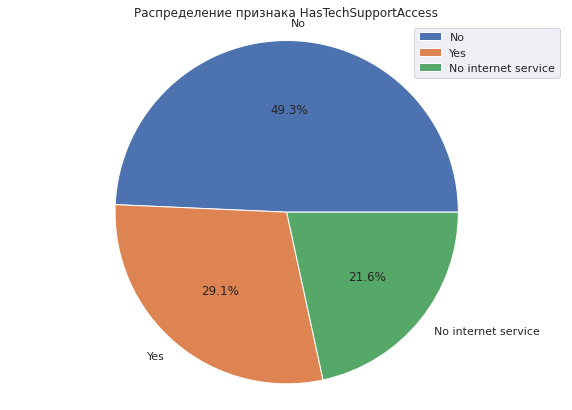

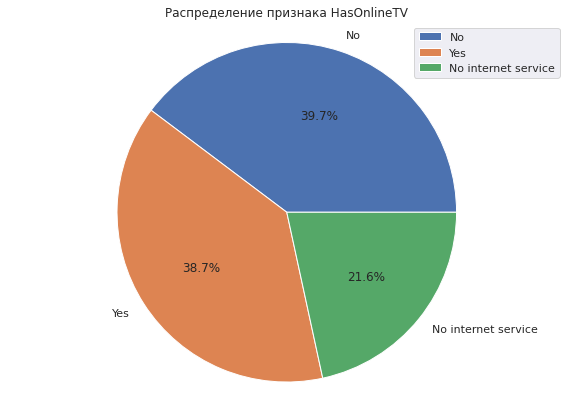

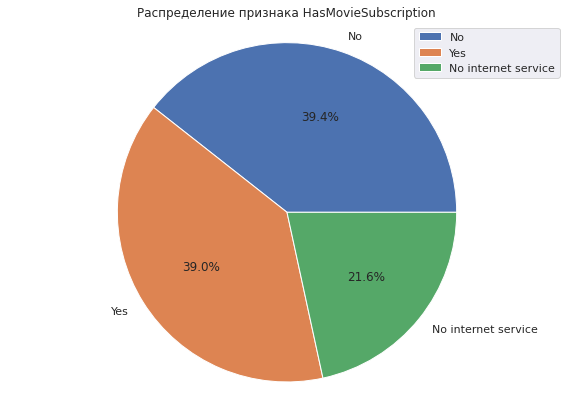

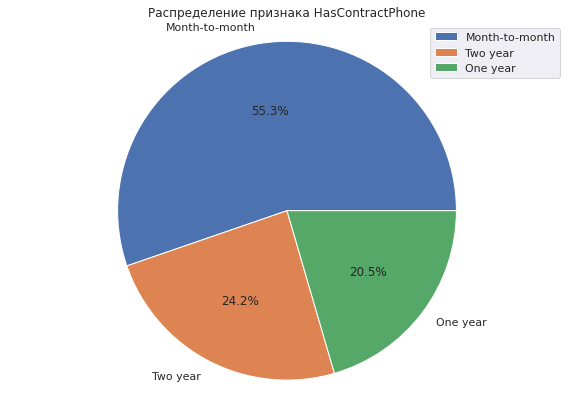

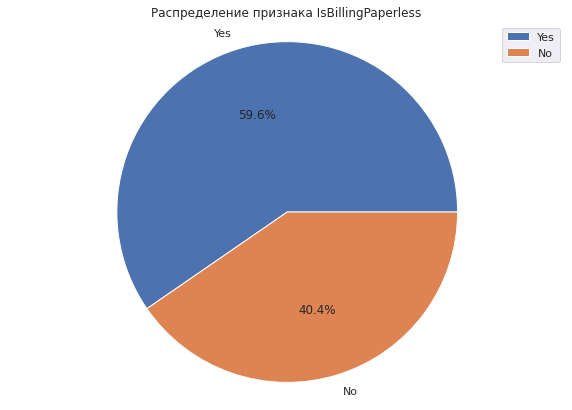

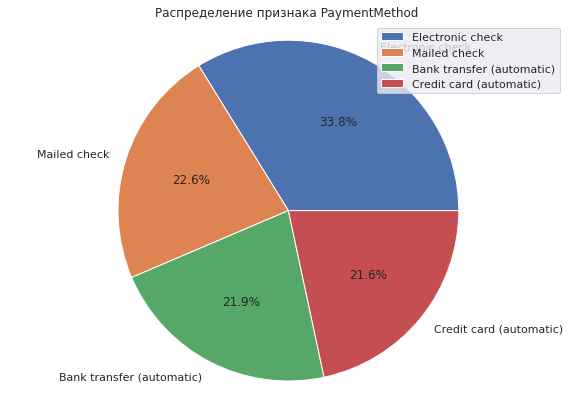

In [ ]:
for x in cat_features:
    plt.figure(figsize=(10, 7))
    plt.pie(df[x].value_counts(), 
            labels=df[x].value_counts().index, 
            autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(f'Распределение признака {x}')
    plt.legend()
    plt.show()
    print()

### Целевая переменная

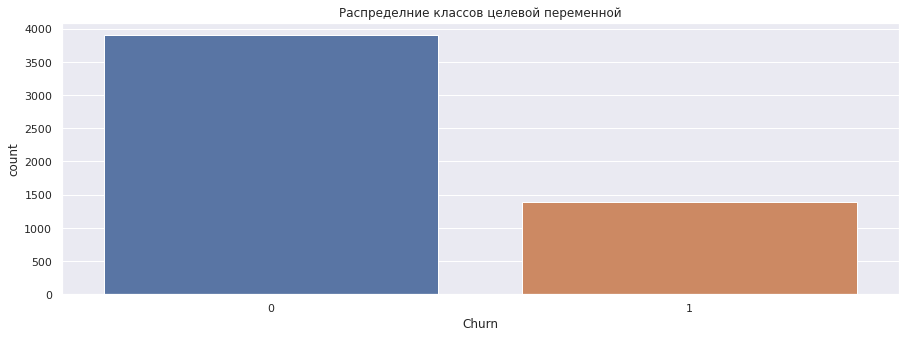

In [ ]:

sns.countplot(df['Churn'])
plt.title('Распределние классов целевой переменной')
plt.show()

**Вывод**: классы не сбалансированы, в данных намного (почти в 3 раза) больше наблюдений класса `0`. Если предсказание класса сделать константным (всем наблюдениям предсказать класс `0`), то метрика `accuracy` будет равна около `0,74`.

## Машинное обучение

### Логистическаая регрессия

Создадим конвейер подготовки количественных признаков:

In [ ]:
num_transformer = make_pipeline(StandardScaler())

Создадим конвейер подготовки качественных признаков:

In [ ]:
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))

Создадим preprocessor для подготовки всех данных:

In [ ]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features)],
                                 verbose_feature_names_out=False)

Создадим финальный конвейер для подготовки данных и обучения алгоритма:

In [ ]:
alg = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('estimator', LogisticRegression(random_state=42))])

Создадим сетку гиперпараметров для алгоритма:

In [ ]:
parameters = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__class_weight': [None, 'balanced'],
    'estimator__solver': ['liblinear'],
    'estimator__max_iter': [100, 300, 500]
}

In [ ]:
gs = GridSearchCV(alg,
                  parameters,
                  cv=5,
                  scoring='roc_auc',
                  verbose=2,
                  n_jobs=2 )

Перебираем гиперпараметры:

In [ ]:
gs.fit(df[X], df[y])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                     

Лучшие гиперпараметры:

In [ ]:
gs.best_params_

{'estimator__class_weight': None,
 'estimator__max_iter': 100,
 'estimator__penalty': 'l2',
 'estimator__solver': 'liblinear'}

Лучшая метрика `ROC_AUC` на обучающей выборке:

In [ ]:
gs.best_score_

0.8449508468379827

### Градиентный бустинг

Делим наш датасет на обучающую и валидационную выборки:

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(df[X], df[y], 
                                                      test_size=0.25, 
                                                      random_state=42)

In [ ]:
train_pool = Pool(data=train_X,
                  label=train_y,
                  cat_features=cat_features
                 )

valid_pool = Pool(data=valid_X,
                  label=valid_y,
                  cat_features=cat_features
                 )

Создаем параметры нашей модели:

In [ ]:
parameters = {'verbose': 100,
              'random_seed': 42, 
              'learning_rate': 0.01,
              'eval_metric': 'AUC',
              'max_depth': 4}

Создаем модель:

In [ ]:
cb = CatBoostClassifier(**parameters)

Обучаем модель:

In [ ]:
cb.fit(train_pool, eval_set=valid_pool)

0:	test: 0.7683541	best: 0.7683541 (0)	total: 10.1ms	remaining: 10.1s
100:	test: 0.8137465	best: 0.8137465 (100)	total: 913ms	remaining: 8.13s
200:	test: 0.8215297	best: 0.8215297 (200)	total: 1.75s	remaining: 6.95s
300:	test: 0.8241302	best: 0.8241302 (300)	total: 2.66s	remaining: 6.18s
400:	test: 0.8254826	best: 0.8254826 (400)	total: 3.51s	remaining: 5.24s
500:	test: 0.8265634	best: 0.8265818 (497)	total: 4.42s	remaining: 4.4s
600:	test: 0.8270470	best: 0.8271176 (585)	total: 5.82s	remaining: 3.86s
700:	test: 0.8275290	best: 0.8275290 (699)	total: 7.74s	remaining: 3.3s
800:	test: 0.8274430	best: 0.8276272 (723)	total: 9.43s	remaining: 2.34s
900:	test: 0.8277639	best: 0.8277731 (899)	total: 10.3s	remaining: 1.13s
999:	test: 0.8279511	best: 0.8279941 (965)	total: 11.2s	remaining: 0us

bestTest = 0.8279941296
bestIteration = 965

Shrink model to first 966 iterations.


Лучшая метрика `ROC_AUC` на обучающей выборке:

In [ ]:
cb.best_score_['validation']['AUC']

0.8279941296391816

## Предсказания

### Логистическая регрессия

Загружаем данные тестовой выборки и сохраняем в переменной `test`: 

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Start/Datasets/Churn/test.csv')
test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


Строковый тип данных в признаке `TotalSpent` необходимо поменять на числовой. Для этого проверим наличие пустых строк c пробелами в столбце `TotalSpent`:

In [ ]:
test[test['TotalSpent'].str.isspace()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


Заменим пустые строки с пробелами на нули:

In [ ]:
test['TotalSpent'] = test['TotalSpent'].replace(' ', '0')

А теперь поменяем тип данных:

In [ ]:
test['TotalSpent'] = test['TotalSpent'].astype(float)

Проверим наличие пустых строк с пробелами и без пробелов во всех категориальных признаках c типом данных `object`:

In [ ]:
test.select_dtypes(include='object').isin([' ', '']).sum()

Sex                         0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

Загружаем файл submission.csv и сохраняем его в переменной `submission`:

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Start/Datasets/Churn/submission.csv')
submission.head()

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Сохранаяем в столбце `Churn` результаты предсказания модели логистической регрессии:

In [ ]:
submission['Churn'] = gs.best_estimator_.predict_proba(test)[:, 1]

In [ ]:
submission.to_csv('lr_submission.csv', index=False)

Метрика `ROC_AUC` на тестовой выборке на платформе `Kaggle`:  **0.84579**.

### Градиентный бустинг

Сохранаяем в столбце `Churn` результаты предсказания модели градиентного бустинга:

In [ ]:
submission['Churn'] = cb.predict_proba(test)[:, 1]

In [ ]:
submission.to_csv('cb_submission.csv', index=False)

Метрика `ROC_AUC` на тестовой выборке на платформе `Kaggle`:  **0.85181**.